<a href="https://colab.research.google.com/github/Huni6102/Huni6102/blob/main/%EA%B8%88%EC%9C%B5%EA%B3%BC%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_2%EA%B0%95_Python%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%9E%AC%EB%AC%B4_%EC%97%B0%EA%B5%AC_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **금융과 인공지능**
## Python을 활용한 재무연구 실습                   

In [ ]:
###################
# Import Packages #
###################

import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import * # MonthEnd
import statsmodels.formula.api as sm
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets

In [ ]:
############################
# 1. Data Collection       #
############################

# set date
start = datetime.datetime(2020,1,1) # start date
end = datetime.datetime(2024,9,6) # end date
print(start)

### download each stocks
SAM = web.DataReader('005930', 'naver', start=start, end=end) # Samsung
LG = web.DataReader('003550', 'naver', start=start, end=end) # LG
HYUN = web.DataReader('005380', 'naver', start=start, end=end) # Hyundai motors

# check datatypes
print(SAM.head(5))
print(SAM.dtypes)
SAM['Close'] = pd.to_numeric(SAM['Close'], errors='coerce')
print(SAM.dtypes)
LG['Close'] = pd.to_numeric(LG['Close'], errors='coerce')
HYUN['Close'] = pd.to_numeric(HYUN['Close'], errors='coerce')

### input name
SAM['ticker'] = 'SAM'
LG['ticker'] = 'LG'
HYUN['ticker'] = 'HYUN'

# sort values
SAM = SAM.reset_index().sort_values(['Date'])
LG = LG.reset_index().sort_values(['Date'])
HYUN = HYUN.reset_index().sort_values(['Date'])

# concatenate matrix
stock_set = pd.concat([SAM, LG, HYUN], ignore_index=True).set_index('Date') # long type
print(stock_set.head(5))
print(stock_set.tail(5))

              Open    High     Low   Close   Volume ticker
Date                                                      
2024-09-02  256000  256000  245000  246000  1006660   HYUN
2024-09-03  244000  244500  236000  237500  1024521   HYUN
2024-09-04  231000  236500  229500  232500   942257   HYUN
2024-09-05  236000  237500  227000  229000   884047   HYUN
2024-09-06  228000  230500  223000  227500   710077   HYUN


In [ ]:
############################################################################
# Ken French's Data Library                                                #
# http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html #
############################################################################
### Data Library List
data_list = get_available_datasets()
len(data_list)

### Get Fama-French 3 Factors (Monthly)

f3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=start, end=end)
print(f3['DESCR']) ## check the data description
f3 = f3[0] # choose monthly data
print(f3.head(5))

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202407 CRSP database. The 1-month TBill rate data until 202405 are from Ibbotson Associates. Starting from 202406, the 1-month TBill rate is from ICE BofA US 1-Month Treasury Bill Index. Copyright 2024 Kenneth R. French

  0 : (55 rows x 4 cols)
  1 : Annual Factors: January-December (4 rows x 4 cols)
         Mkt-RF   SMB    HML    RF
Date                              
2020-01   -0.11 -3.13  -6.25  0.13
2020-02   -8.13  1.07  -3.80  0.12
2020-03  -13.39 -4.79 -13.88  0.13
2020-04   13.65  2.45  -1.34  0.00
2020-05    5.58  2.49  -4.85  0.01


<ipython-input-58-064509530c45>:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  f3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=start, end=end)
<ipython-input-58-064509530c45>:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  f3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=start, end=end)


In [ ]:
############################
# 2. Data Transformation   #
############################

### fama-french 3 factor (MKT, SMB, HML)
f3 = f3/100 # scaling the values
f3 = f3.reset_index()
f3 = f3.rename(columns = {'Mkt-RF': 'MKT', 'date': 'Date'}) # rename the column

### convert daily price to monthly return
print(stock_set.head())
monthly = stock_set.groupby(['ticker']).resample('M').last() # resample with month end data # change 'M' to 'ME' for python 3.9 if it generate errors.
print(monthly.head())
monthly = monthly.drop(['ticker'], axis=1).reset_index() # use drop when you want to drop certain column
monthly['Close'] = pd.to_numeric(monthly['Close'], errors='coerce')

monthly['ret'] = monthly.groupby(['ticker'])['Close'].pct_change()  # (P_{t} / P_{t-1})-1
monthly['logret'] = monthly.groupby('ticker')['Close'].transform(lambda x: np.log(x) - np.log(x.shift(1)))  # ln(P_{t} / P_{t-1}) = ln(P_{t}) - ln(P_{t-1}) => ln(A/B) = ln(A) - ln(B)

### Pivot
print(monthly.head())
data = monthly.pivot(index='Date', columns='ticker', values='ret')
data = data.reset_index()
print(data.head())
data['Date'] = pd.to_datetime(data['Date']).dt.to_period('M')
print(data.head())
print(f3.head())

### Merge with FF3
data = pd.merge(data, f3, how='left', on=['Date'])
print(data.head(5))

             Open   High    Low  Close    Volume ticker
Date                                                   
2020-01-02  55500  56000  55000  55200  12993228    SAM
2020-01-03  56000  56600  54900  55500  15422255    SAM
2020-01-06  54900  55600  54600  55500  10278951    SAM
2020-01-07  55700  56400  55600  55800  10009778    SAM
2020-01-08  56200  57400  55900  56800  23501171    SAM
                     Open    High     Low   Close   Volume ticker
ticker Date                                                      
HYUN   2020-01-31  128500  129500  124500  125000  1035126   HYUN
       2020-02-29  118500  119000  114000  115000  1777353   HYUN
       2020-03-31   87700   88700   86000   88700  2138183   HYUN
       2020-04-30   93500   94000   92400   93600  1193284   HYUN
       2020-05-31   96300   99200   96300   98000  2010414   HYUN
  ticker       Date    Open    High     Low   Close   Volume       ret  \
0   HYUN 2020-01-31  128500  129500  124500  125000  1035126       NaN  

In [ ]:
############################
# 3. Data Analysis         #
############################

### Data Description
data = data.set_index('Date')
print(data)
print(data.describe())

### Correlation Matrix
corr = data.corr()
print(corr)

### Regression
reg_data = data.copy().dropna() # drop missing values
print(reg_data.head())
reg_data['SAM_ex'] = reg_data['SAM']- reg_data['RF']
reg_data['LG_ex'] = reg_data['LG']- reg_data['RF']
reg_data['HYUN_ex'] = reg_data['HYUN'] - reg_data['RF']

ols_SAM = sm.ols(formula = 'SAM_ex~MKT+SMB+HML', data = reg_data).fit()
print(ols_SAM.summary())
print(ols_SAM.params)
print(ols_SAM.tvalues)
ols_LG = sm.ols(formula = 'LG_ex~MKT+SMB+HML', data = reg_data).fit()
print(ols_LG.summary())
print(ols_LG.params)
print(ols_LG.tvalues)
ols_HYUN = sm.ols(formula = 'HYUN_ex~MKT+SMB+HML', data = reg_data).fit()
print(ols_HYUN.summary())
print(ols_HYUN.params)
print(ols_HYUN.tvalues)

                            OLS Regression Results                            
Dep. Variable:                  LG_ex   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     6.205
Date:                Tue, 10 Sep 2024   Prob (F-statistic):            0.00115
Time:                        04:36:18   Log-Likelihood:                 59.915
No. Observations:                  54   AIC:                            -111.8
Df Residuals:                      50   BIC:                            -103.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0007      0.012     -0.061      0.9

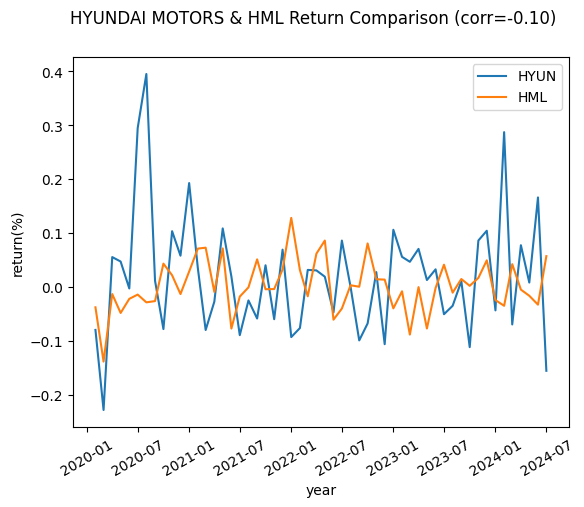

In [ ]:
############################
# 4. Data Visualization    #
############################
### Graph
# box plot
# reg_data = reg_data.apply(pd.to_numeric, errors='coerce')
boxplot = reg_data.boxplot(column=['SAM','LG','HYUN','MKT','SMB','HML'])
plt.show()
print(reg_data[['SAM','LG','HYUN','MKT','SMB','HML']].describe())

# plot SAMSUNG return and MKT return (corr=0.61)

line5 = plt.plot(reg_data.index.to_timestamp(), reg_data[['SAM']], label='SAM')
line6 = plt.plot(reg_data.index.to_timestamp(), reg_data[['MKT']], label='MKT')

plt.xticks(rotation=30)
plt.legend()
plt.xlabel('year')
plt.ylabel('return(%)')
plt.suptitle('SAMSUNG & MKT Return Comparison (corr=0.61)')
plt.show()
# plt.savefig('samsung_mkt.png', bbox_inches='tight') # save plot

# plot Ford return and HML return (corr=-0.10)

line7 = plt.plot(reg_data.index.to_timestamp(), reg_data[['HYUN']], label='HYUN')
line8 = plt.plot(reg_data.index.to_timestamp(), reg_data[['HML']], label='HML')

plt.xticks(rotation=30)
plt.legend()
plt.xlabel('year')
plt.ylabel('return(%)')
plt.suptitle('HYUNDAI MOTORS & HML Return Comparison (corr=-0.10)')
plt.show()
# plt.savefig('hyundai_hml.png', bbox_inches='tight') # save plot


In [ ]:
### Output

SAM_result = round(pd.concat((ols_SAM.params, ols_SAM.tvalues), axis=1).rename(columns={0: 'SAMSUNG_beta', 1: 'SAMSUNG_t'}), 3)
LG_result = round(pd.concat((ols_LG.params, ols_LG.tvalues), axis=1).rename(columns={0: 'LG_beta', 1: 'LG_t'}), 3)
HYUN_result = round(pd.concat((ols_HYUN.params, ols_HYUN.tvalues), axis=1).rename(columns={0: 'HYUNDAI_beta', 1: 'HYUNDAI_t'}), 3)

print(SAM_result)

result = pd.concat((SAM_result, LG_result, HYUN_result), axis=1)
print(result)
# result.to_csv('result.csv', sep=',')

           SAMSUNG_beta  SAMSUNG_t  LG_beta   LG_t  HYUNDAI_beta  HYUNDAI_t
Intercept         0.000      0.019   -0.001 -0.061         0.007      0.494
MKT               0.744      5.012    0.774  3.683         0.990      4.048
SMB               0.336      1.281    0.394  1.061         0.140      0.324
HML               0.065      0.389   -0.149 -0.630        -0.274     -0.996
